In [1]:
import numpy as np
import astropy as ap
import scipy as sp
from scipy import stats
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In general, most of the np.randoms will be replaced with a distribution of some sort. Using random for now since it's easy and convenient.

A lot of this code is overly verbose and can be greatly reduced taking advantage of numpy. Writing it like this so it is uber clear what we are doing and how we are doing it. We should convert/simplify a lot of this using numpy size= feature.

Plotting noise is going to be a bit iffy with healpy, should look into map2alm shenanigans.

This also doesn't take into account for time, but we can just space those evenly through the interval (k / total_interval) in our code.

TQDM is completely optional and just for some eye candy. Makes it a lot easier to see progress in for loops.

In [216]:
# Constants and other setup variables. Event rates are events/year. Spherical points should be (theta, phi)
low_energy_rate = 50
high_energy_rate = 70
low_energy_resolution = (.3, .3)
high_energy_resolution = (.3, .3)
lisa_resolution = (.3, .3)
NSIDE = 128
Npix = hp.nside2npix(NSIDE)

In [217]:
time_vals = [10, 1000, 10000, 100000, 1000000]

In [219]:
emri_rate = 50
mbh_rate = 12
time_diff = 10

In [138]:
def add_time():
    time = np.random.randint(86400*365*1000)
    return time

In [139]:
# Get a random point on a sphere (uniform distribution). LISA should be fairly uniform and so should IceCube Gen II
def random_point():
    phi = np.random.random()*2*np.pi
    costheta = np.random.random()*2 - 1
    theta = np.arccos(costheta)
    return [theta, phi]

In [198]:
def plot_gaussian_event(etheta, ephi, sigma, amp):
    theta,phi=hp.pix2ang(NSIDE,np.arange(Npix))
    return amp*np.exp(-((phi - ephi)**2+(theta - etheta)**2)/(2*sigma**2))

In [141]:
def healpix_smooth(etheta, ephi, sig, amp):
    pind = hp.ang2pix(NSIDE, etheta, ephi)
    temp = np.zeros(Npix)
    temp[pind] = amp
    return hp.smoothing(temp, sigma=sig)

In [142]:
# Super simplified noise function. Returns a random (theta, phi) based on low energy or high energy. 
# Actual function should take the position into account, use the dec dependence, then generate noise
def add_noise_hen(low_energy):
    noise = [0,0]
    if low_energy:
        noise[0] = np.random.random()*l_noise[0]
        noise[1] = np.random.random()*l_noise[1]
        return noise
    else:
        noise[0] = np.random.random()*high_noise[0]
        noise[1] = np.random.random()*high_noise[1]
        return noise

In [143]:
# Gets low energy neutrino events (10 TeV to < 1 PeV)
def low_energy_hen():
    points = []
    noise = []
    time = []
    k = np.random.poisson(lam=low_energy_rate)
    energy = np.random.random(k)*5
    for i in range(k):
        points.append(random_point())
        noise.append(add_noise_hen(True))
        time.append(add_time())
    return [np.array(points), np.array(noise), energy, np.array(time)]

In [144]:
# Gets high energy neutrino events (> 1 PeV events)
def high_energy_hen():
    points = []
    noise = []
    time = []
    k = np.random.poisson(lam=high_energy_rate)
    energy = np.random.random(k)*10+5
    for i in range(k):
        points.append(random_point())
        noise.append(add_noise_hen(False))
        time.append(add_time())
    #print(np.array(time))
    return [np.array(points), np.array(noise), energy, np.array(time)]

In [ ]:
def general_event(poisson_lambda):
    points = []
    noise = []
    time = []
    k = np.random.poisson(lam=poisson_lambda)
    for i in range(k):
        points.append(random_point())
        noise.append(add_noise_hen(False))
        time.append(add_time())
    #print(np.array(time))
    return [np.array(points), np.array(noise), np.array(time)]

In [186]:
low_points, low_noise, low_energy, low_time = low_energy_hen()
ltemp = np.zeros(Npix)
for i, v in enumerate(low_points):
    ltemp += plot_gaussian_event(*v, np.linalg.norm(low_noise[i]), 1)

In [189]:
# "Wrapper" function. What the MC run will call to get the HEN events. 
def hen_event():
    low_points, low_noise, low_energy, low_time = low_energy_hen()
    high_points, high_noise, high_energy, high_time = high_energy_hen()
    # Use healpix to plot points and stuff on sphere (ignoring noise for making plot)
    low_map = np.zeros(Npix)
    for i, v in enumerate(low_points):
        low_map += plot_gaussian_event(*v, np.linalg.norm(low_noise[i]), 1)
    high_map = np.zeros(Npix)
    for i,v in enumerate(high_points):
        high_map += plot_gaussian_event(*v, np.linalg.norm(high_noise[i]), 1)
    return low_points, high_points, low_time, high_time, low_noise, high_noise, low_map, high_map

Use the same format as the ones above to create the gw_events but use EMRI and SMBH instead. While it is awfully repetitive right now, it's better in the long run since it offers both clarity and customizability in the future. 


In [146]:
def add_noise_gw():
    noise = [0,0]
    noise[0] = np.random.random()*lisa_resolution[0] #need to find resolution #s
    noise[1] = np.random.random()*lisa_resolution[1]
    return noise

In [147]:
def emri_event():
    point = []
    noise = []
    time = []
    k = np.random.poisson(lam=emri_rate)
    for i in range(k):
        point.append(random_point())
        noise.append(add_noise_gw())
        time.append(add_time())
    return [np.array(point), np.array(noise), np.array(time)]

In [148]:
def mbh_event():
    point = []
    noise = []
    time = []
    k = np.random.poisson(lam=mbh_rate)
    for i in range(k):
        point.append(random_point())
        noise.append(add_noise_gw())
        time.append(add_time())
    return [np.array(point), np.array(noise), np.array(time)]

In [190]:
def gw_event():
    emri_point, emri_noise, emri_time = emri_event()
    mbh_point, mbh_noise, mbh_time = mbh_event()
    emri_map = np.zeros(Npix)
    for i,v in enumerate(emri_point):
        emri_map += plot_gaussian_event(*v, np.linalg.norm(emri_noise[i]), 1)
    mbh_map = np.zeros(hp.nside2npix(NSIDE))
    for i,v in enumerate(mbh_point):
        mbh_map += plot_gaussian_event(*v, np.linalg.norm(mbh_noise[i]), 1)
    return emri_point, mbh_point, emri_time, mbh_time, emri_noise, mbh_noise, emri_map, mbh_map

In [150]:
def position_overlap(p1, p2, n1, n2):
    pvec1 = hp.ang2vec(*p1)
    pvec2 = hp.ang2vec(*p2)
    p1_disk = hp.query_disc(256, pvec1, n1, inclusive=True)
    p2_disk = hp.query_disc(256, pvec2, n2, inclusive=True)
    overlap = np.intersect1d(p1_disk, p2_disk)
    return len(overlap)

In [151]:
def time_overlap(t1,t2):
    d = {}
    for i,v in enumerate(t1):
        a = np.where(t2 < v + time_diff)[0] 
        b = np.where(t2 > v - time_diff)[0]
        c = np.intersect1d(a,b)
        if len(c) > 0:
            d[i] = c
    return d

In [152]:
def overlap(e1,e2,n1,n2,t1,t2):
    time_worthy = time_overlap(t1, t2)
    overlap_counter = 0
    pairs_overlap = []
    for i,v in enumerate(time_worthy):
        pos_1 = e1[v]
        noise_1 = np.linalg.norm(n1[v])
        for k in time_worthy[v]:
            pos_2 = e2[k]
            noise_2 = np.linalg.norm(n2[k])
            l = position_overlap(pos_1, pos_2, noise_1, noise_2)
            if l > 0:
                pairs_overlap.append((v,k))
                overlap_counter += 1

    return overlap_counter, pairs_overlap

In [208]:
def monte_carlo_run():
    l, h, lt, ht, ln, hn, _, _ = hen_event()
    emri, mbh, et, mt, en, mn, _, _ = gw_event()
    # overlap is ju    
    l_e, _ = overlap(l,emri,ln,en,lt,et)
    l_m, _ = overlap(l,mbh,ln,mn,lt,mt)
    h_e, _ = overlap(h,emri,hn,en,ht,et)
    h_m, _ = overlap(h,mbh,hn,mn,ht,mt)
    return np.array([l_e, l_m, h_e, h_m])

In [209]:
# Actual monte carlo function. Most of the code heavy lifting should be done elsewhere
def mc(n=100):
    lval = []
    for k in time_vals:
        global time_diff = k
        for i in tqdm(range(n)):
            lval.append(np.sum(monte_carlo_run()))
    return lval

In [210]:
m = mc(100)

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

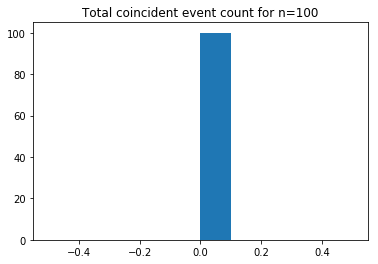

In [211]:
plt.title("Total coincident event count for n=100");
plt.hist(m)

In [204]:
_, _, _, _, _, _, lmap, hmap = hen_event()
_, _, _, _, _, _, emap, mmap = gw_event()


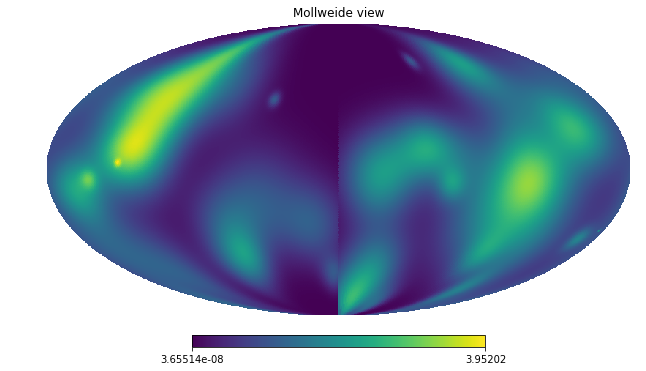

In [205]:
hp.mollview(emap)

In [2]:
k = (3,3)

In [5]:
np.random.normal()*np.array(k)

array([2.44593519, 2.44593519])